# Profile of CPD python implementation

CPD model was implemented in pure python language, using `scipy` and `numpy` functions for efficient calculations.

The performance of CPD python are evaluated against the python wrapper to the CPD `Fortran` code. Note that the wrapper executes CPD externally and than loads the results.

The versions used for this profiling are:

In [1]:
import pkp
import cpd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['mystyle-vega'])

In [2]:
print('PKP version: {}'.format(pkp.__version__))
print('CPD version: {}'.format(cpd.__version__))

PKP version: 2.4.3+2.g4f4cc36.dirty
CPD version: 0.0.2+2.ga5825ec.dirty


In [3]:
ua = {'C': 74.12, 'H': 4.96, 'O': 13.18, 'N': 1.45, 'S': 0}
pa = {'FC': 57, 'VM': 43, 'Ash': 0, 'Moist': 0}
p = 101325
coal = cpd.CPD(ultimate_analysis=ua, proximate_analysis=pa, pressure=p, 
               name='test')
operating_conditions = [[0, 600], [0.01, 1200], [0.02, 1200]]
coal.operating_conditions = operating_conditions

The following coal is used for the analysis:

In [4]:
print ("Ultimate analysis")
print ("=================")
for k, v in ua.items():
    print ("{:<8} {:<15.2%}".format(k, v/100))

Ultimate analysis
C        74.12%         
H        4.96%          
O        13.18%         
N        1.45%          
S        0.00%          


In [5]:
print ("Proximate analysis")
print ("=================")
for k, v in pa.items():
    print ("{:<8} {:<15.2%}".format(k, v/100))

Proximate analysis
FC       57.00%         
VM       43.00%         
Ash      0.00%          
Moist    0.00%          


## Python CPD with Numpy interpolation

The first test is done using the `Numpy` interpolation routine, which shows the following performances:

In [6]:
pkp.reactor.interp = np.interp

In [7]:
coal.set_parameters(dt=1e-6, dt_max=1e-4)
cpd_py = %timeit -o res = coal.run()

/Users/vascella/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1035: UserWarning: dopri5: larger nmax is needed
  self.messages.get(idid, 'Unexpected idid=%s' % idid))
/Users/vascella/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1035: UserWarning: dopri5: larger nmax is needed
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


The slowest run took 6.36 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 81.4 ms per loop


## Fortran CPD with python wrapper

The second test is done using the `Fortran` CPD with the Python wrapper:

In [8]:
coal0 = pkp.cpd.CPD(ultimate_analysis=ua, proximate_analysis=pa, pressure=p, 
               name='test')
coal0.operating_conditions = operating_conditions

In [9]:
coal0.set_parameters(dt=1e-6, dt_max=1e-4)
cpd_f = %timeit -o res0 = coal0.run()

10 loops, best of 3: 27.2 ms per loop


The original `Fortran` CPD code is faster:

In [10]:
print('CPD fortan/CPD python: {:4.2%}'.format(cpd_f.best/cpd_py.best))

CPD fortan/CPD python: 33.39%


It is not a extreme difference, but keep in mind that the wrapper is also reading the results from file!

## Python CPD with jit compiled interpolation

The third test is done using the python CPD with `Numba` jit interpolation routine:

In [11]:
pkp.reactor.interp = pkp.interpolate.interp

In [12]:
coal1 = cpd.CPD(ultimate_analysis=ua, proximate_analysis=pa, pressure=p, 
               name='test')
coal1.operating_conditions = operating_conditions
coal1.set_parameters(dt=1e-6, dt_max=1e-4)

In [13]:
cpd_nb = %timeit -o res = coal1.run()

/Users/vascella/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1035: UserWarning: dopri5: larger nmax is needed
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


10 loops, best of 3: 78.3 ms per loop


This shows a slight improvements compared to the original python:

In [14]:
print('CPD python/CPD numba: {:4.2%}'.format(cpd_py.best/cpd_nb.best))

CPD python/CPD numba: 103.95%


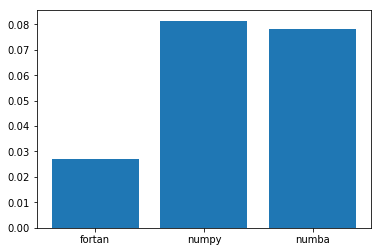

In [15]:
res = ('fortan', 'numpy', 'numba')
best = [r.best for r in (cpd_f, cpd_py, cpd_nb)]

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()

ax.bar(np.arange(3), best)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(res)
#ax.set_yscale('log')

In [16]:
%prun -s cumtime res = coal.run()

/Users/vascella/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1035: UserWarning: dopri5: larger nmax is needed
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


# Interpolate profiling

Using `numba` jit interpolate can give a quite good improvement in the interpolation routine:

In [ ]:
x = np.linspace(-5, 5, 1001)
y = np.exp(x)

In [ ]:
%timeit np.interp(0.34, x, y)

In [ ]:
%timeit pkp.interpolate.interp(0.34, x, y)

## Binomial

Binomial is also consuming a lot of CPU time. The `scipy` implementation is not very efficient. For this reason an alternative version was created using the $\gamma$ function.

In [ ]:
cpd.binomial

In [ ]:
n = 50
%timeit cpd.binomial(np.arange(n), n, 0.1)

In [ ]:
from scipy.stats import binom

In [ ]:
%timeit binom.pmf(np.arange(n), n, 0.1)

In [ ]:
%timeit res = coal.run()

In [ ]:
cpd.binomial = binom.pmf
%timeit res = coal.run()

# Gamma function

In [ ]:
import math

In [ ]:
math.lgamma(0.5)

In [ ]:
from scipy import special

In [ ]:
special.gammaln(0.5)

In [ ]:
%timeit math.lgamma(0.5)

In [ ]:
%timeit special.gammaln(0.5)

In [ ]:
import numba

In [ ]:
@numba.jit(nopython=True)
def gammaln(x):
    return math.lgamma(x)

In [ ]:
gammaln(0.5)

In [ ]:
%timeit gammaln(0.5)